In [561]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Split the data into training and testing

To train the data, first need to split it into the data that the model will be trained on and the data the model will be assessed on. Here we are using median house value as the prediction of the model.

In [562]:
data = pd.read_csv("cleaned_housing.csv")
data.columns

Index(['Unnamed: 0', 'housing_median_age', 'median_income',
       'median_house_value', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'coordinates'],
      dtype='object')

In [563]:
data.rename({"ocean_proximity_<1H OCEAN": "ocean_proximity_under_1H OCEAN"}, axis=1, inplace=True) # XGBoost model doesn't allow "<"
X = data.drop(["median_house_value", "Unnamed: 0"], axis=1, errors="ignore")
# Median house value removed as it is the answer the model will be tested on and Unnamed column appears with pandas usage
y = data["median_house_value"]

In [564]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14303, 11)
(6130, 11)
(14303,)
(6130,)


## Creating models

In [565]:
# Linear regression model:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Forest regression model:
rf_model = RandomForestRegressor(n_estimators=10,random_state=10)
rf_model.fit(X_train, y_train)

# XGBoost model:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Testing models' accuracy

In [566]:
# Linear regression model:
y_lr_pred_test = reg_model.predict(X_test)
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_lr_pred_test, "Accuracy %": (y_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_lr_pred_test) * 100 , 2))

         Actual      Predicted  Accuracy %
11471  228900.0  281813.920477  123.116610
16276  155000.0   80600.908691   52.000586
19747   60000.0   74869.772091  124.782953
17608  156800.0  254300.812028  162.181640
15700  333100.0  255954.992563   76.840286
Avrg accuracy %: 112.00449874074421
61.02


In [567]:
# Forest regression model:
y_rf_pred_test = rf_model.predict(X_test)
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_rf_pred_test, "Accuracy %": (y_rf_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_rf_pred_test) * 100 , 2))

         Actual  Predicted  Accuracy %
16321  244200.0   141360.0   57.886978
5198   500001.0   497210.9   99.441981
1130   101200.0    97270.0   96.116601
18056  197200.0   299500.1  151.876318
7582   158200.0   171540.0  108.432364
Avrg accuracy %: 107.15371709241468
75.38


In [568]:
# XGBoost model:
y_xgb_pred_test = xgb_model.predict(X_test)
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_xgb_pred_test, "Accuracy %": (y_xgb_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_xgb_pred_test) * 100 , 2))

        Actual      Predicted  Accuracy %
9809  153200.0  150418.921875   98.184675
9688  135000.0  180099.562500  133.407083
6173  166800.0  171391.109375  102.752464
5815  250000.0  257235.609375  102.894244
5566  164200.0  170040.421875  103.556895
Avrg accuracy %: 106.79620574831326
78.17


## Important features
* The data that contributes the most to the predictions

Model can be built only using the most important features to simplify analysis of the predictions.

#### Forest regression model has a method feature importances which shows the most important features that are used by the model to calculate the prediction

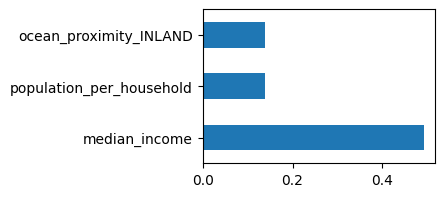

In [569]:
# Forest regression model:
plt.figure(figsize=(3,2))
feat_importances = pd.Series(rf_model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(3).plot(kind="barh"); # plot 3 of the highest importance with side bar-plot

#### For other models, we can calculate the most important features and visualise in the similar way by using model's coefficient data

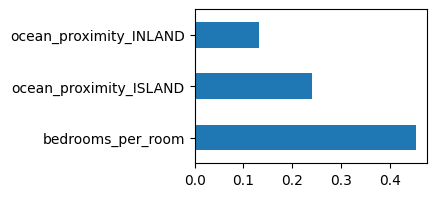

In [570]:
# Linear regression model:
coefficients = abs(reg_model.coef_) # as some weigh in the separate direction (.coef_ is similar to feature importances)
coef_df = pd.Series(coefficients/sum(coefficients), index = X_train.columns) # feature names and coefficients of the model
plt.figure(figsize=(3, 2))
coef_df.nlargest(3).plot(kind="barh");

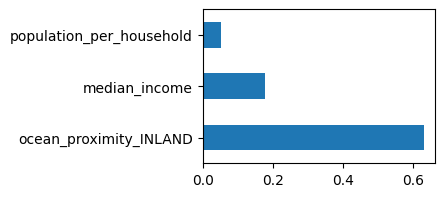

In [578]:
# XGBoost model:
coef_df = pd.Series(xgb_model.feature_importances_, index = X_train.columns) # has feature_importances_ method
plt.figure(figsize=(3, 2))
coef_df.nlargest(3).plot(kind="barh");

## Modifying model's parameters

In [572]:
# Current parameters which can be adjusted:
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [573]:
# Creating a second xgb model but with modified parameters this time:
xgb_model_2 = XGBRegressor(
    gamma=0.05,
    learning_rate=0.01,
    max_depth=6,
    n_estimators=1000,
    n_jobs=16,
    objective="reg:squarederror",
    subsample=0.8,
    scale_pos_weight=0,
    reg_alpha=0,
    reg_lambda=1,
    verbosity=1)

xgb_model_2.fit(X_train, y_train)
y_xgb_2_pred_test = xgb_model_2.predict(X_test)

In [574]:
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_xgb_2_pred_test, "Accuracy %": (y_xgb_2_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_xgb_2_pred_test) * 100 , 2))

         Actual      Predicted  Accuracy %
2794    67000.0   70906.351562  105.830375
19343   76300.0  109446.210938  143.441954
11230  161800.0  162005.906250  100.127260
7932   209100.0  200729.312500   95.996802
19437  141800.0  115809.867188   81.671274
Avrg accuracy %: 107.31877442513836
79.21


## Saving and reusing a model

In [575]:
# Save the models to a file
models_to_save = {"linear_regression_model": reg_model, "forest_regression_model": rf_model,
                  "xgb_model": xgb_model, "xgb_model_2": xgb_model_2}
for model_name, model in models_to_save.items():
    with open(f"{model_name}.pkl", "wb") as model_file:
        pickle.dump(model, model_file)

In [576]:
# To use a model:
with open("xgb_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)